## 영상 처리 모델

### 1. 프레임 안의 모든 번호판 객체를 탐지

#### 1-1. 모델 학습

* 1-1. 모델 학습에 해당하는 코드는 <u>학습 과정의 예시(샘플 데이터, 10 epochs)</u>를 <u>코랩에서 실행하여 가져온 것</u>입니다. 

In [2]:
%%capture
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install super-gradients==3.1.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

In [2]:
# 런타임 다시시작

In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import sys

import super_gradients
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import models

import locale
locale.getpreferredencoding = lambda: "UTF-8"

The console stream is logged into /root/sg_logs/console.log


[2023-07-06 03:42:59] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-07-06 03:43:11] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-07-06 03:43:11] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-07-06 03:43:11] WARNING - export.py - Failed to import pytorch_quantization
[2023-07-06 03:43:11] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [2]:
CHECKPOINT_DIR = 'files/checkpoints'
trainer = Trainer(experiment_name='aivle19', ckpt_root_dir=CHECKPOINT_DIR)

In [3]:
dataset_params = {
    'data_dir':'/content/files/data',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'classes':['license']
}

In [4]:
train_data = coco_detection_yolo_format_train(

    # training set 데이터 위치 명시
    dataset_params = {
        'data_dir' : dataset_params['data_dir'],
        'images_dir' : dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },

    # parameter 명시
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }

)

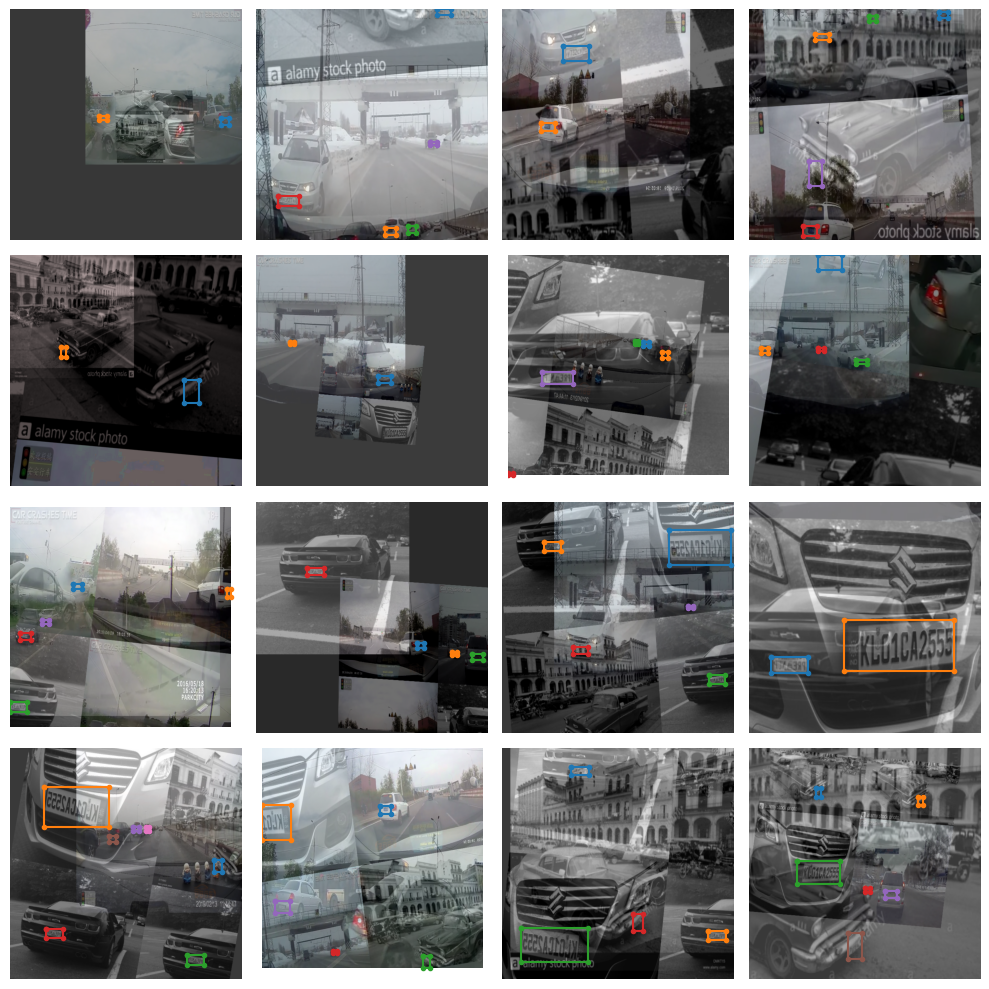

In [5]:
# 샘플 이미지 16장만 추출. 실제로는 약 300장의 사진을 학습에 활용
train_data.dataset.plot()

In [6]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

In [7]:
val_data = coco_detection_yolo_format_val(

    # validation set 데이터 위치 명시
    dataset_params = {
        'data_dir' : dataset_params['data_dir'],
        'images_dir' : dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },

    # parameter 명시
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }

)

In [8]:
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights='coco'
                   )

[2023-07-06 03:43:59] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


  0%|          | 0.00/73.1M [00:00<?, ?B/s]

Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth


In [9]:
train_params = {

    'silent_mode': True,
    'average_best_models':True,
    'warmup_mode': "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay":0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay":0.9, "decay_type": "threshold"},

    # 10에폭 학습하는 예시 코드
    # 실제로는 60에폭 학습
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max = 16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions = 300,

            # 클래스 수 명시
            num_cls = len(dataset_params['classes']),
            normalize_targets = True,
            post_prediction_callback = PPYoloEPostPredictionCallback(
              score_threshold=0.01,
              nms_top_k = 1000,
              max_predictions = 300,
              nms_threshold=0.6
            )
        )
    ],
    "metric_to_watch": "mAP@0.50"
}

In [10]:
# 코랩 환경에서 학습
trainer.train(model=model, training_params=train_params,
            train_loader=train_data,
            valid_loader=val_data,
             )

[2023-07-06 03:44:03] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to files/checkpoints/aivle19/console_Jul06_03_44_07.txt


[2023-07-06 03:44:12] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 17         (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         1          (len(train_loader))
    - Gradient updates per epoch:   1          (len(train_loader) / batch_accumulate)

[2023-07-06 03:44:24] INFO - base_sg_logger.py - Checkpoint saved in files/checkpoints/aivle19/ckpt_best.pth
[2023-07-06 03:44:24] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.002361853839829564
[2023-07-06 03:45:10] INFO - base_sg_logger.py - Checkpoint saved in files/ch

SUMMARY OF EPOCH 10
├── Training
│   ├── Ppyoloeloss/loss = 2.7396
│   │   ├── Best until now = 2.923  (↘ -0.1833)
│   │   └── Epoch N-1      = 2.923  (↘ -0.1833)
│   ├── Ppyoloeloss/loss_cls = 1.2755
│   │   ├── Best until now = 1.3249 (↘ -0.0494)
│   │   └── Epoch N-1      = 1.4333 (↘ -0.1578)
│   ├── Ppyoloeloss/loss_dfl = 1.3182
│   │   ├── Best until now = 1.3705 (↘ -0.0522)
│   │   └── Epoch N-1      = 1.3705 (↘ -0.0522)
│   └── Ppyoloeloss/loss_iou = 0.322
│       ├── Best until now = 0.2897 (↗ 0.0323)
│       └── Epoch N-1      = 0.3218 (↗ 0.0002)
└── Validation
    ├── F1@0.50 = 0.0556
    │   ├── Best until now = 0.0231 (↗ 0.0325)
    │   └── Epoch N-1      = 0.0231 (↗ 0.0325)
    ├── Map@0.50 = 0.022
    │   ├── Best until now = 0.0604 (↘ -0.0384)
    │   └── Epoch N-1      = 0.0604 (↘ -0.0384)
    ├── Ppyoloeloss/loss = 3.0664
    │   ├── Best until now = 2.8784 (↗ 0.1881)
    │   └── Epoch N-1      = 2.8784 (↗ 0.1881)
    ├── Ppyoloeloss/loss_cls = 1.6956
    │   ├── Best 

#### 1-2. 모델 활용

* 1-2. 모델 활용에 해당하는 코드 부터는 jupyter notebook 환경에서 실행했습니다.

In [98]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import sys

import super_gradients
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import models

import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [99]:
# 'yolo_nas_s' 모델 구조를 사용하며, num_classes는 해당 모델이 번호판 객체만 인식하는 모델이므로 여기서는 1로 설정
# checkpoint_path는 커스템 데이터셋으로 학습된 모델의 가중치를 저장한 파일의 경로
yolo_mdl = models.get('yolo_nas_s', num_classes = 1, checkpoint_path="files/ckpt_best.pth")

In [100]:
img_url = 'files/test_frame.jpg'

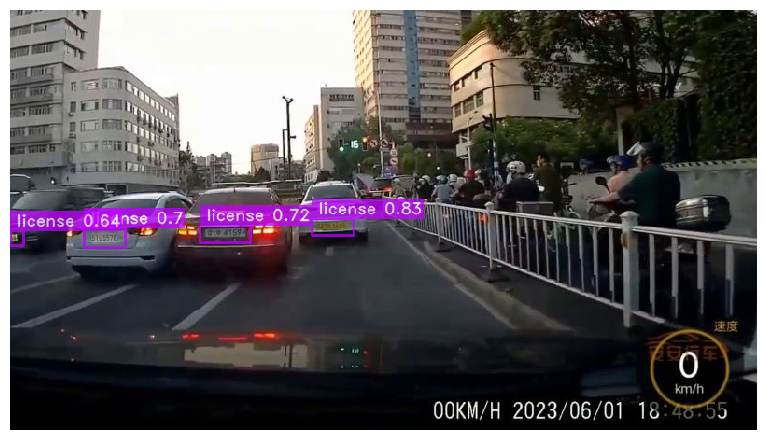

In [126]:
# img_url 경로에 있는 이미지를 예측한 결과
yolo_mdl.predict(img_url).show()

#### 1-3. 검출된 번호판 좌표 반환

In [102]:
# img_url에 있는 이미지를 예측한 결과를 predictions 변수에 저장
predictions = yolo_mdl.predict(img_url)

# predictions에서 객체들의 리스트를 가져옴
predicted_objects = list(predictions._images_prediction_lst)[0]

# 객체들의 바운딩 박스 좌표 정보를 가져옴
boundings = predicted_objects.prediction.bboxes_xyxy

In [103]:
# 첫번째 객체의 바운딩 박스 정보
boundings[1]

array([203.09842, 230.51172, 257.77887, 249.17172], dtype=float32)

In [104]:
img_url

'files/test_frame.jpg'

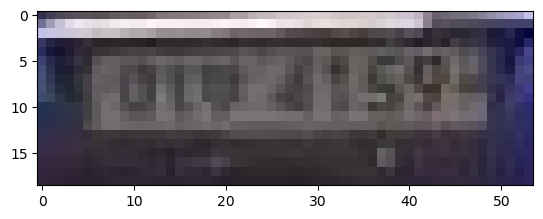

In [105]:
img = cv2.imread(img_url)

# 번호판의 위치만 출력하여 확인
plt.imshow(img[int(boundings[1][1]):int(boundings[1][3]),int(boundings[1][0]):int(boundings[1][2])])

In [106]:
# 바운딩 박스에 해당하는 영역을 추출하여 저장할 폴더를 만듬
os.mkdir("files/lp/license_plates")

In [107]:
# 폴더에 번호판 객체만 저장
cv2.imwrite("files/lp/license_plates/bounding_box_1.jpg",img[int(boundings[1][1]):int(boundings[1][3]),int(boundings[1][0]):int(boundings[1][2])])

True

### 2. OCR 진행

* 2. OCR 진행은 예시 데이터를 활용하여 실행했습니다.

In [131]:
#!pip install paddlepaddle -i https://pypi.tuna.tsinghua.edu.cn/simple

In [109]:
#!pip install "paddleocr>=2.0.1"

In [110]:
#!pip install protobuf==3.20

In [111]:
from paddleocr import PaddleOCR,draw_ocr
import os

In [112]:
# 한국어 인식 OCR 모델을 가져옴
ocr = PaddleOCR(use_angle_cls = True,
                cls_thresh = 0.7,
                lang='korean')

dataset_path = 'files/plates'

# 레이블 저장공간
label_list = []

# 데이터셋 경로에 있는 프레임에 대하여 실행
for frames in os.listdir(dataset_path):

    img_path = dataset_path + '/' + frames

    # 이미지에 OCR 수행
    result = ocr.ocr(img_path, cls=True)

    # OCR 결과를 레이블 리스트에 추가
    label_list.append(result)

    for idx in range(len(result)):
        res = result[idx]

        # 결과를 출력하여 확인
        for line in res:
            print(line)

In [113]:
label_list

[[[[[[154.0, 101.0], [982.0, 91.0], [984.0, 245.0], [156.0, 256.0]],
    ('01부415', 0.7718165516853333)]]],
 [[[[[44.0, 38.0], [115.0, 46.0], [111.0, 74.0], [40.0, 65.0]],
    ('283부', 0.8239580988883972)],
   [[[117.0, 45.0], [190.0, 54.0], [186.0, 84.0], [113.0, 75.0]],
    ('8268', 0.9999546408653259)]]]]

In [114]:
json_list = []
df = pd.DataFrame(columns = ['number', 'license plate number'])
n = 0

for i in range(len(label_list)):

    for objects in label_list[i][0]:

        # 개체를 JSON 형식으로 변환
        json_data = json.dumps(objects)

        # ']]' 를 기준으로 분할
        split_txt = json_data.split(']],')

        json_list.append(json_data)

        # 번호판 정보를 추출
        license_plate = split_txt[1].split(',')[0].replace('[','').replace(' ','').replace('"','')

        # 데이터프레임에 행 추가
        df = df.append({'number':n, 'license plate number':license_plate}, ignore_index=True)

        n += 1

In [115]:
# 데이터베이스에 저장
df

,number,license plate number
0,0,01\ubd80415
1,1,283\ubd80
2,2,8268


### 3. 해당 부분 마스킹 작업 진행

In [116]:
def mosaic(img, ratio=0.1):
    try:
        # 이미지를 축소
        small = cv2.resize(img, None, fx=ratio, fy=ratio, interpolation=cv2.INTER_NEAREST)

        # 축소된 이미지를 원래 크기로 다시 확대하여 모자이크 효과 적용
        return cv2.resize(small, img.shape[:2][::-1], interpolation=cv2.INTER_NEAREST)

    except:
        return img

def mosaic_area(img, x, y, width, height, ratio=0.1):
    frame = img.copy()

     # 바운딩 박스에 모자이크 효과 적용
    frame[y:y + height, x:x + width] = mosaic(frame[y:y + height, x:x + width], ratio)
    return frame

to_mask = []

for i in range(len(boundings)):

    # 바운딩 박스의 영역을 불러옴
    x = int(boundings[i][0])
    y = int(boundings[i][1])
    width = int(boundings[i][2]) - int(boundings[i][0])
    height = int(boundings[i][3]) - int(boundings[i][1])

     # 모자이크를 적용할 영역으로 리스트에 추가
    to_mask.append([x, y, width, height])

In [117]:
to_mask

[[323, 223, 45, 18], [203, 230, 54, 19], [79, 233, 44, 21], [0, 236, 14, 16]]

In [118]:
frame = cv2.imread(img_url)

for x,y,width,height in to_mask:

    # 모자이크 효과를 적용한 프레임으로 업데이트
    frame = mosaic_area(frame, x, y, width, height, ratio=0.05)

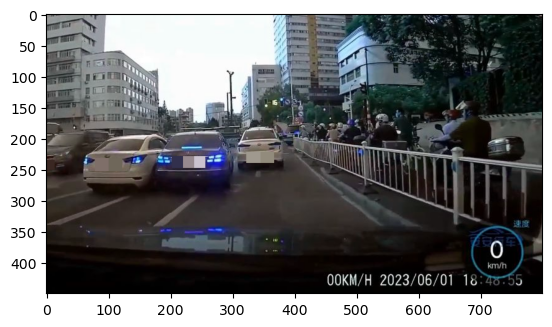

In [119]:
plt.imshow(frame)

## 4. 영상의 모든 프레임에 대해 1-3진행

In [121]:
os.mkdir("files/masked")

dataset_path = 'files/frames'
images = os.listdir(dataset_path)
yolo_mdl = models.get('yolo_nas_s', num_classes = 1, checkpoint_path="files/ckpt_best.pth")

for image in images:
    img_path = dataset_path + '/' + image

    predictions = yolo_mdl.predict(img_path, conf=0.3)
    predicted_objects = list(predictions._images_prediction_lst)[0]

    boundings = predicted_objects.prediction.bboxes_xyxy

    to_mask = []

    for i in range(len(boundings)):

        x = int(boundings[i][0])
        y = int(boundings[i][1])
        width = int(boundings[i][2]) - int(boundings[i][0])
        height = int(boundings[i][3]) - int(boundings[i][1])

        to_mask.append([x, y, width, height])

    frame = cv2.imread(img_path)

    for x,y,width,height in to_mask:
        frame = mosaic_area(frame, x, y, width, height, ratio=0.05)

    cv2.imwrite(f"files/masked/{image}",frame)

## 5. 비디오 생성

In [122]:
height, width, layers = cv2.imread('files/masked/frame_000.jpg').shape
video = cv2.VideoWriter("video.mp4", 0, 10, (width, height))

In [123]:
dataset_path = 'files/masked'
video_frames = os.listdir(dataset_path)

# 비디오 프레임별로 반복
for frame in video_frames:
    frame_path = dataset_path + '/' + frame

    frame = cv2.imread(frame_path)

    # 비디오에 프레임을 쌓아나감
    video.write(frame)

In [124]:
video.release()